# APS Failure at Scania Trucks

Data Source: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks

### Relevent Information
The dataset consists of data collected from heavy Scania 
trucks in everyday usage. The system in focus is the 
**Air Pressure system (APS)** which generates pressurised 
air that are utilized in various functions in a truck, 
such as braking and gear changes. 
 
### Label Info
 1. **pos:** consists of component failures 
 for a specific component of the APS system
 
 2. **neg:** consists of trucks with failures 
 for components not related to the APS
 
 The data consists 
 of a subset of all available data, selected by experts.
 


**Number of Instance:** 60000<br>
**Number of positive:**  1000<br>
**Number of negative:** 59000


### Attribute Info

**Number of Attributes:** 170 + 1(class label)

1. The attribute names of the data have been anonymized for 
   proprietary reasons
 <br><br>
2. consists of both single numerical 
   counters and histograms consisting of bins with different 
   conditions.
 <br><br>
3. Typically the histograms have open-ended 
   conditions at each end. For example if we measuring 
   the ambient temperature "T" then the histogram could 
   be defined with 4 bins where: 

   bin 1 collect values for temperature T < -20<br>
   bin 2 collect values for temperature T >= -20 and T < 0     
   bin 3 collect values for temperature T >= 0 and T < 20  
   bin 4 collect values for temperature T > 20 

       |  b1  |  b2  |  b3  |  b4  |   
       ----------------------------- 
             -20     0      20
 <br><br>
4. The attributes are as follows: class, then 
  anonymized operational data. The operational data have 
  an identifier and a bin id, like "Identifier_Bin".
  In total there are 171 attributes, of which 7 are 
  histogram variabels. Missing values are denoted by "na".

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from MulticoreTSNE import MulticoreTSNE as TSNE


%matplotlib inline
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=15)
sns.set_style('whitegrid')

pd.set_option('display.max_columns', 200)

# To fix disk space error while
# performing grid-search in parallel
%env JOBLIB_TEMP_FOLDER=/tmp

# to fix freeze with n_jobs > 1
%env JOBLIB_START_METHOD="forkserver"

env: JOBLIB_TEMP_FOLDER=/tmp
env: JOBLIB_START_METHOD="forkserver"


# Read Data

In [2]:
train = pd.read_csv('aps_failure_training_set.csv', skiprows=20, na_values='na')
test  = pd.read_csv('aps_failure_test_set.csv',     skiprows=20, na_values='na')

# Explore Data

In [7]:
print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (60000, 171)
Test shape (16000, 171)


In [4]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,0.0,5374.0,2108.0,4114.0,12348.0,615248.0,5526276.0,2378.0,4.0,0.0,0.0,2328746.0,1022304.0,415432.0,287230.0,310246.0,681504.0,1118814.0,3574.0,0.0,0.0,6700214.0,0.0,10.0,108.0,50.0,2551696.0,97518.0,947550.0,799478.0,330760.0,353400.0,299160.0,305200.0,283680.0,NaN,NaN,NaN,178540.0,76698.08,6700214.0,6700214.0,6599892.0,43566.0,68656.0,54064.0,638360.0,6167850.0,1209600.0,246244.0,2.0,96.0,0.0,5245752.00,0.0,916567.68,6.0,1924.0,0.0,0.0,0.0,118196.0,1309472.0,3247182.0,1381362.0,98822.0,11208.0,1608.0,220.0,240.0,6700214.0,NaN,10476.0,1226.0,267998.0,521832.0,428776.0,4015854.0,895240.0,26330.0,118.0,0.0,532.0,734.0,4122704.0,51288.0,0.0,532572.0,0.0,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,0.0,7336.0,7808.0,13776.0,13086.0,1010074.0,1873902.0,14726.0,6.0,0.0,0.0,1378576.0,447166.0,199512.0,154298.0,137280.0,138668.0,165908.0,229652.0,87082.0,4708.0,3646660.0,86.0,454.0,364.0,350.0,1393352.0,49028.0,688314.0,392208.0,341420.0,359780.0,366560.0,NaN,NaN,NaN,NaN,NaN,6700.0,33057.51,3646660.0,3646660.0,3582034.0,17733.0,260120.0,115626.0,6900.0,2942850.0,1209600.0,0.0,NaN,NaN,NaN,2291079.36,0.0,643536.96,0.0,0.0,0.0,0.0,38.0,98644.0,1179502.0,1286736.0,336388.0,36294.0,5192.0,56.0,NaN,0.0,3646660.0,NaN,6160.0,796.0,164860.0,350066.0,272956.0,1837600.0,301242.0,9148.0,22.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,0.0,1620.0,1156.0,1228.0,34250.0,1811606.0,710672.0,34.0,0.0,0.0,0.0,790690.0,672026.0,332340.0,254892.0,189596.0,135758.0,103552.0,81666.0,46.0,0.0,2673338.0,128.0,202.0,576.0,4.0,1234132.0,28804.0,160176.0,139730.0,137160.0,13064

In [5]:
test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,3862.0,1846.0,0.0,0.0,0.0,3976.0,0.0,0.0,0.0,1520.0,2374.0,11516.0,9480.0,111258.0,470.0,0.0,0.0,0.0,0.0,58.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13124.0,2.0,1956.0,434.0,76.0,174.0,190.0,6198.0,1148.0,2948.0,2.0,0.0,8762.0,2566.0,480.0,380.0,196.0,516.0,86.0,66.0,74.0,0.0,124340.0,4.0,6.0,4.0,0.0,3976.0,318.0,107662.0,3458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110980.0,59.53,124340.0,124340.0,184970.0,54.0,686.0,12246.0,123880.0,13196.0,1209600.0,598.0,0.0,6.0,0.0,5913.60,0.00,5851.20,6.0,30.0,0.0,2.0,5512.0,4674.0,1388.0,1508.0,38.0,4.0,0.0,0.0,8.0,12.0,124340.0,0.0,1550.0,14.0,36.0,26.0,920.0,430.0,7650.0,2294.0,206.0,0.0,22.0,42.0,5336.0,1276.0,0.0,0.0,0.0,0.0,6598.0,70.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,0.0,0.0,1100.0,574.0,232.0,66.0,780.0,882.0,0.0,4.0,0.0,0.0,0.0,465.50,90.0,7502.0,3156.0,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,12594.0,3636.0,0.0,0.0,0.0,5244.0,0.0,60.0,0.0,0.0,0.0,23174.0,18166.0,23686.0,1270.0,0.0,0.0,0.0,0.0,12.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,692.0,16286.0,0.0,280.0,44.0,50.0,1274.0,866.0,3362.0,11102.0,0.0,0.0,0.0,12564.0,1756.0,638.0,276.0,172.0,132.0,812.0,308.0,192.0,128.0,46894.0,4.0,2.0,38.0,0.0,5244.0,360.0,20520.0,3134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23320.0,81.89,46894.0,46894.0,48324.0,68.0,0.0,4486.0,46480.0,17050.0,1209600.0,726.0,2.0,4.0,0.0,7224.96,0.00,7768.32,0.0,42.0,0.0,0.0,4.0,7064.0,6200.0,2452.0,1246.0,12.0,0.0,0.0,14.0,54.0,46894.0,0.0,2202.0,28.0,114.0,350.0,700.0,1708.0,9622.0,2174.0,80.0,0.0,80.0,206.0,7802.0,1466.0,0.0,0.0,0.0,0.0,7918.0,78.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.0,0.0,0.0,3996.0,584.0,200.0,62.0,37580.0,3756.0,6368.0,36.0,0.0,0.0,0.0,2.86,102.0,10040.0,3310.0,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,1952422.0,452706.0,25130.0,520.0,0.0,1891670.0,0.0,0.0,0.0,77898.0,110548.0,3605894.0,3291610.0,959756.0,286536.0,0.0,0.0,0.0,0.0,106.0,340.0,0.0,0.0,0.0,0.0,0.0,24286.0,681260.0,2808472.0,474782.0,0.0,22984.0,894.0,1162.0,1304.0,1856.0,388700.0,3424812.0,123828.0,23260.0,0.0,1662580.0,667960.0,387998.0,226078.0,161558.0,148288.0,154908.0,220820.0,147744.0,210866.0,4644422.0,958.0,7848.0,3624.0,0.0,1891670.0,47066.0,692800.0,265492.0,336240.0,194360.0,245240.0,NaN,NaN,NaN,NaN,NaN,175480.0,66002.89,4644422.0,4644422.0,4608738.0,22706.0,2272.0,95510.0,1006260.0,3991552.0,1209600.0,126310.0,0.0,104.0,0.0,3594885.12,0.00,374649.60,148.0,720.0,0.0,5154.0,174956.0,622312.0,1002504.0,793938.0,541734.0,345896.0,300806.0,201500.0,52.0,92.0,4644422.0,0.0,24818.0,964.0,162660.0,215004.0,217930.0,3038612.0,322718.0,6080.0,14.0,0.0,226.0,572.0,3593728.0,1911060.0,0.0,284.0,0.0,0.0,3613906.0,

In [6]:
train.dtypes.value_counts()

float64    169
int64        1
object       1
dtype: int64

We have 170 anonymized features all of them are numerical, in the csv file they look integers but for some reason pandas is assigning them as floats except for one

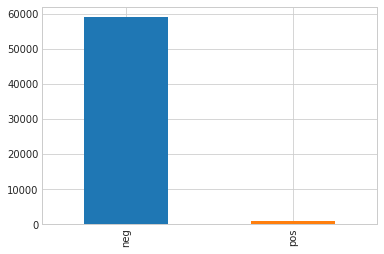

In [7]:
# Plot distribution of class labels
train['class'].value_counts().plot(kind='bar');

Our data is heavily imbalanced

Looks like APS failure does not occur often

In [8]:
# Percentage of NaNs for each column (sorted)
missing_col = train.isna().mean().sort_values()
missing_col

class     0.000000
aa_000    0.000000
bt_000    0.002783
ck_000    0.005633
cj_000    0.005633
ci_000    0.005633
by_000    0.007883
aq_000    0.009817
bi_000    0.009817
bj_000    0.009817
ao_000    0.009817
au_000    0.010483
at_000    0.010483
as_000    0.010483
aj_000    0.010483
ai_000    0.010483
am_0      0.010483
ap_000    0.010700
bh_000    0.010700
bg_000    0.010700
an_000    0.010700
al_000    0.010700
ah_000    0.010750
bb_000    0.010750
cs_009    0.011150
cs_005    0.011150
cs_001    0.011150
cs_006    0.011150
cs_008    0.011150
cs_004    0.011150
            ...   
ca_000    0.072600
ak_000    0.073333
ed_000    0.159217
cl_000    0.159217
cm_000    0.164617
ec_00     0.170650
dc_000    0.230133
db_000    0.230133
da_000    0.230133
cz_000    0.230133
cy_000    0.230133
cu_000    0.230133
cv_000    0.230133
ct_000    0.230133
cx_000    0.230133
ad_000    0.247683
ch_000    0.247683
cg_000    0.247683
co_000    0.247683
cf_000    0.247683
bk_000    0.383900
bl_000    0.

All the feature columns have missing values except `aa_000`

percentage of missing values ranges from 0 to 82%
so some of the features have a very large number of missing values

Lets see the relative missing values of all the columns

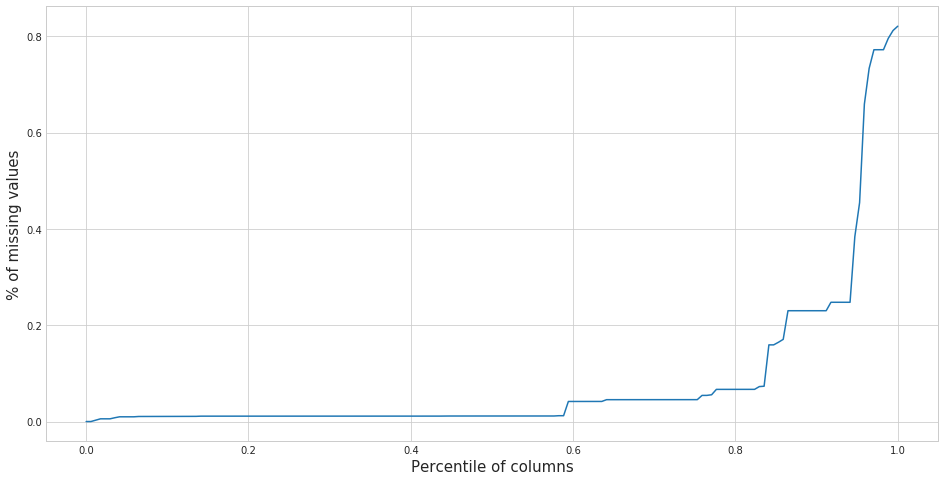

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(np.linspace(0, 1, len(missing_col)), missing_col)
plt.xlabel('Percentile of columns')
plt.ylabel('% of missing values');

It appears that there is a pattern in the missing values

And there are certain groups of features based on the number of missing values

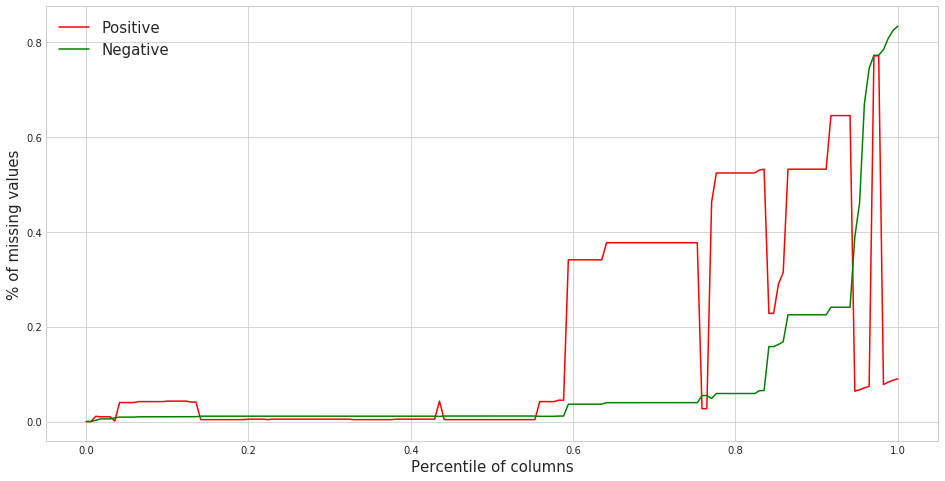

In [10]:
# Percentage of missing values of columns grouped by class label
percnt_miss = train.groupby('class').apply(lambda df: df.isna().mean()).T

# Sort by global missing values
percnt_miss['Total'] = missing_col
percnt_miss.sort_values('Total', inplace=True)

plt.figure(figsize=(16, 8))
plt.plot(np.linspace(0, 1, len(percnt_miss)),percnt_miss['pos'], 'r', label='Positive')
plt.plot(np.linspace(0, 1, len(percnt_miss)),percnt_miss['neg'], 'g', label='Negative')
plt.xlabel('Percentile of columns')
plt.ylabel('% of missing values')
plt.legend();

It appears that the missing values of `pos` and `neg` class have a slightly different pattern of missingness 

especially for higher values of global missing values.

Also dropping features with high missing values may not be a good idea as for some of those features has low missing value ratio for `pos` class so it may prove usefull for classification

In [3]:
# Percentage of NaNs for each row (sorted)
missing_row = train.isna().mean(axis=1).sort_values()
missing_row

26962    0.000000
49009    0.000000
40780    0.000000
10249    0.000000
3481     0.000000
48969    0.000000
22659    0.000000
48924    0.000000
32994    0.000000
44452    0.000000
3495     0.000000
649      0.000000
10199    0.000000
10195    0.000000
48733    0.000000
33002    0.000000
29193    0.000000
25411    0.000000
34132    0.000000
40686    0.000000
44548    0.000000
48803    0.000000
18862    0.000000
49024    0.000000
7254     0.000000
12507    0.000000
28851    0.000000
7062     0.000000
49374    0.000000
53103    0.000000
           ...   
44793    0.982456
44676    0.982456
21617    0.982456
14510    0.982456
29124    0.982456
53196    0.982456
28255    0.982456
53286    0.982456
10236    0.982456
24059    0.982456
22833    0.982456
22881    0.982456
19202    0.982456
10477    0.982456
54653    0.982456
10898    0.982456
43448    0.982456
3657     0.982456
10715    0.982456
3733     0.982456
13500    0.982456
43705    0.982456
43794    0.982456
32841    0.982456
54238    0

In [12]:
# Number of rows that does not contain missing values
(missing_row == 0).sum()

591

Only 591 (0.98%) rows has zero missing values in rows

the percenatege of missing columns for each rows ranges from 0 to 98%

Lets plot the relative missing columns for each row

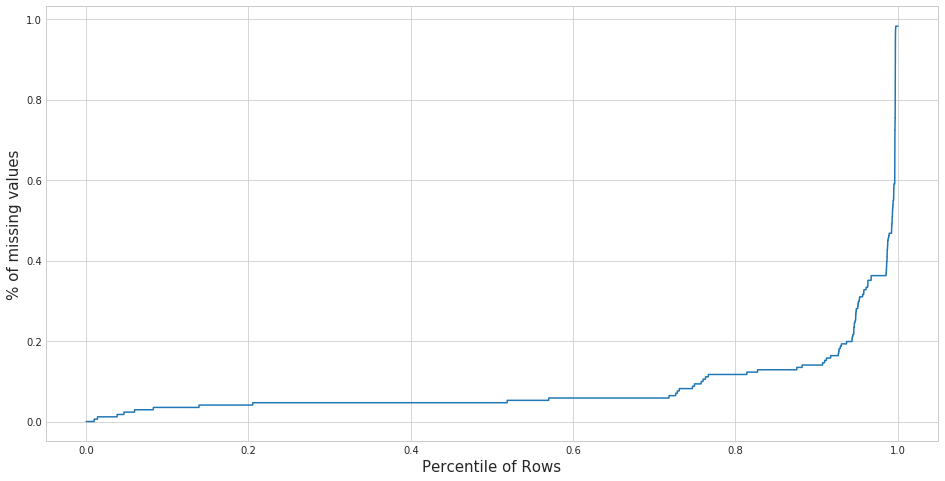

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(np.linspace(0, 1, len(missing_row)),missing_row)
plt.xlabel('Percentile of Rows')
plt.ylabel('% of missing values');

It looks there there are small small groups of rows which have the same proportion of missing values

In [15]:
# Rows that have greater than 
start = int(0.3*len(missing_row))
end = int(0.5*len(missing_row))
idx = missing_row.iloc[start:end].index
train.loc[idx, :].head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
58095,neg,50556,NaN,2.130706e+09,216.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,46576.0,2186576.0,607332.0,12206.0,0.0,1262998.0,0.0,0.0,0.0,0.0,0.0,2703860.0,2483696.0,410544.0,180324.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,19500.0,996408.0,1729194.0,107842.0,0.0,2088.0,392.0,900.0,30992.0,2404010.0,413466.0,1096.0,0.0,0.0,0.0,722028.0,673692.0,275718.0,234356.0,218268.0,222092.0,503728.0,3062.0,0.0,0.0,3114798.0,0.0,10.0,0.0,0.0,1262998.0,27196.0,302480.0,106938.0,90420.0,114600.0,NaN,NaN,NaN,NaN,NaN,NaN,200480.0,50556.38,3114798.0,3114798.0,3131424.0,16928.0,0.0,67098.0,690100.0,2852944.0,1209600.0,1140.0,2.0,42.0,0.0,2589493.44,0.00,261069.12,0.0,0.0,0.0,0.0,0.0,0.0,454480.0,1623448.0,711472.0,51882.0,9616.0,2046.0,66.0,0.0,3114798.0,NaN,4276.0,588.0,72426.0,170880.0,269784.0,2175138.0,158340.0,1512.0,0.0,0.0,298.0,770.0,2571906.0,10608.0,0.0,146.0,0.0,36.0,2607160.0,38.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14190.0,0.0,0.0,0.0,0.0,812.0,192.0,30940.0,3090.0,0.0,0.0,0.0,0.0,0.0,1667.28,1244.0,284812.0,439294.0,289578.0,139364.0,291406.0,245706.0,259732.0,258326.0,640352.0,4374.0,0.0,0.0
58093,neg,38264,NaN,1.800000e+02,164.0,0.0,0.0,0.0,0.0,0.0,0.0,622.0,99554.0,1420864.0,1018674.0,88194.0,110.0,1144638.0,0.0,0.0,0.0,0.0,0.0,2218446.0,1756976.0,673522.0,393752.0,0.0,0.0,0.0,0.0,254.0,78.0,0.0,0.0,0.0,0.0,0.0,8516.0,1673848.0,489192.0,456462.0,0.0,2980.0,2616.0,6096.0,230540.0,2083598.0,302142.0,46.0,0.0,0.0,0.0,1129480.0,429864.0,216584.0,177272.0,166838.0,464338.0,43642.0,0.0,0.0,0.0,2892540.0,0.0,1066.0,134.0,54.0,1144638.0,38266.0,340478.0,331136.0,299320.0,281800.0,NaN,NaN,NaN,NaN,NaN,NaN,86620.0,38264.91,2892540.0,2892540.0,2878360.0,16669.0,2006.0,42352.0,467200.0,2628018.0,1209600.0,74196.0,2.0,126.0,0.0,2027866.56,0.00,598274.88,0.0,0.0,0.0,0.0,0.0,440.0,282404.0,1207936.0,965336.0,157294.0,12578.0,2030.0,2.0,16.0,2892540.0,NaN,4152.0,608.0,80390.0,401510.0,163650.0,1175832.0,787940.0,13844.0,92.0,0.0,380.0,234.0,2016802.0,167444.0,0.0,8546.0,0.0,38.0,2062356.0,2198.0,260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22142.0,38318.0,6506.0,0.0,0.0,64158.0,17406.0,85660.0,27812.0,0.0,0.0,0.0,0.0,0.0,1046.52,1188.0,632082.0,440146.0,199024.0,110806.0,237508.0,196060.0,165422.0,128694.0,402384.0,115892.0,0.0,0.0
58092,neg,148,4.0,2.130706e+09,44.0,0.0,0.0,0.0,0.0,0.0,26.0,23850.0,5460.0,3656.0,0.0,0.0,0.0,1874.0,0.0,0.0,0.0,1810.0,2602.0,56320.0,54912.0,9798.0,1488.0,0.0,0.0,0.0,0.0,22.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2052.0,30940.0,0.0,94.0,68.0,696.0,474.0,82.0,652.0,11844.0,18262.0,820.0,0.0,28612.0,2244.0,628.0,328.0,190.0,226.0,496.0,72.0,32.0,164.0,67962.0,8.0,4.0,0.0,2.0,1874.0,282.0,5080.0,4688.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9540.0,148.50,67962.0,67962.0,68840.0,62.0,0.0,6668.0,67680.0,33054.0,1209600.0,730.0,2.0,10.0,0.0,6817.92,0.00,25240.32,6.0,26

From the above table it looks like only the number of missing values of each row remain the same but they are not necessarily same in the same columns

In [9]:
traintest = pd.concat([train, test], axis = 0)

In [17]:
# `dropna = False` makes nunique treat NaNs as a distinct value
feats_counts = train.nunique(dropna = False)

In [18]:
feats_counts.sort_values().head(10)

class      2
cd_000     2
ch_000     3
as_000    22
ef_000    29
ab_000    30
dz_000    48
eg_000    50
cs_009    54
au_000    57
dtype: int64

In [19]:
feats_counts.sort_values().tail(10)

ck_000    45044
bt_000    45481
ci_000    45965
ao_000    47724
an_000    48205
bv_000    49347
cq_000    49348
bu_000    49350
bb_000    49393
bx_000    52849
dtype: int64

In [20]:
traintest['cd_000'].value_counts(dropna=False)

 1209600.0    75139
NaN             861
Name: cd_000, dtype: int64

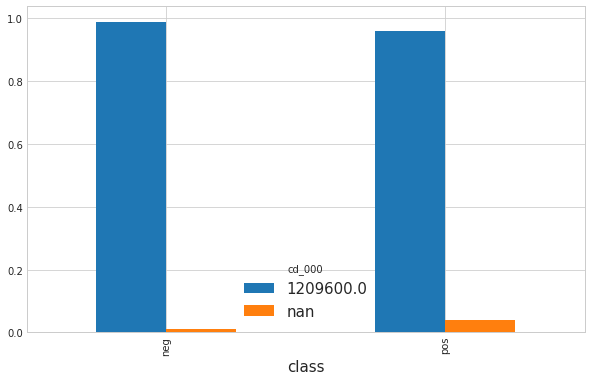

In [21]:
traintest.groupby('class') \
    .apply(lambda df: df['cd_000'].value_counts(dropna=False) / len(df)) \
    .plot(kind='bar', figsize=(10, 6));

In [22]:
traintest['ch_000'].value_counts(dropna=False)

 0.0    57145
NaN     18842
 2.0       13
Name: ch_000, dtype: int64

In [23]:
traintest.groupby('class') \
    .apply(lambda df: df['ch_000'].value_counts(dropna=False) / len(df))

class     
neg    0.0    0.759638
       NaN    0.240201
       2.0    0.000161
pos    NaN    0.666909
       0.0    0.332364
       2.0    0.000727
Name: ch_000, dtype: float64

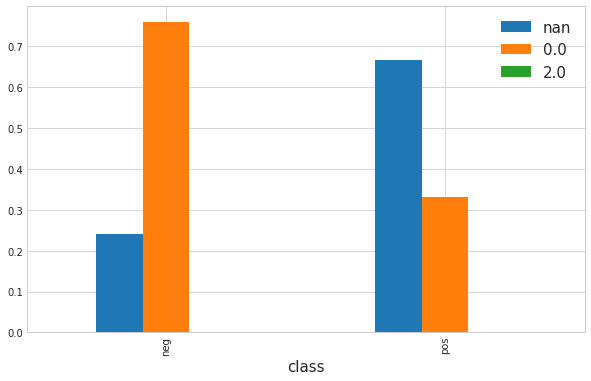

In [25]:
traintest.groupby('class') \
    .apply(lambda df: df['ch_000'].value_counts(dropna=False) / len(df)) \
    .unstack() \
    .plot(kind='bar', figsize=(10, 6));

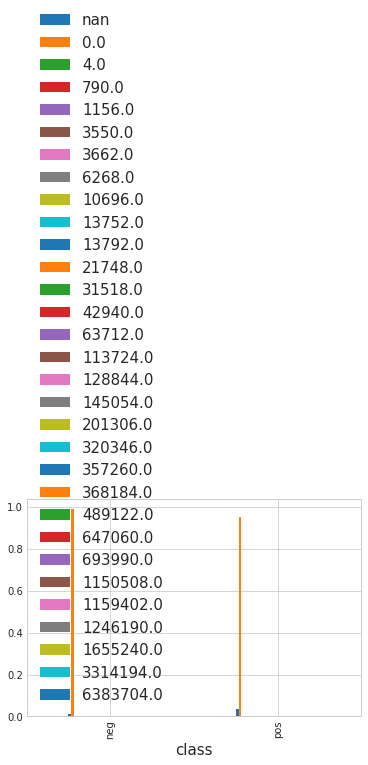

In [11]:
traintest.groupby('class') \
    .apply(lambda df: df['as_000'].value_counts(dropna=False) / len(df)) \
    .unstack() \
    .plot(kind='bar')

In [24]:
import missingno as msno

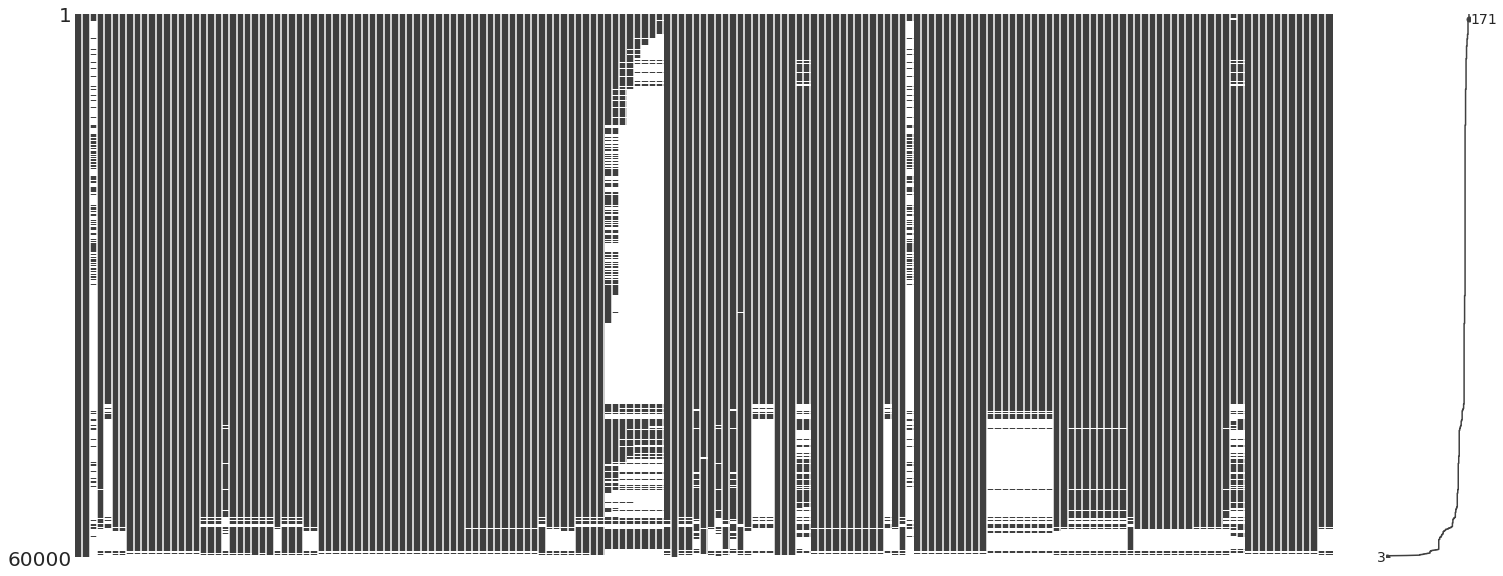

In [36]:
msno.matrix(train, sort='descending')

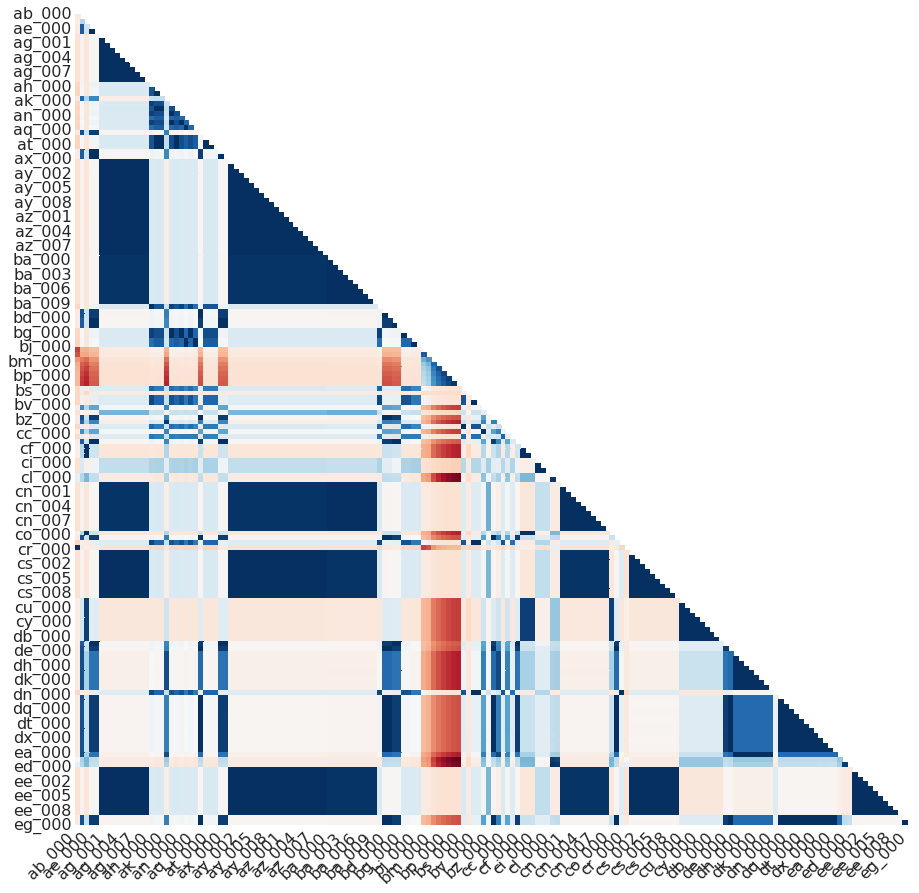

In [46]:
msno.heatmap(train, labels=False, figsize=(15, 15));

# Clean data

In [4]:
train_clean = train[missing_row == 0]

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [56]:
train_clean.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
16,neg,31300,0.0,784.0,740.0,0.0,0.0,0.0,0.0,0.0,20386.0,847078.0,2404100.0,2645236.0,2415620.0,1957818.0,459032.0,4730560.0,0.0,0.0,0.0,38582.0,60878.0,10050600.0,9473796.0,2022538.0,530234.0,0.0,0.0,0.0,0.0,1736.0,1164.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1958836.0,8790434.0,0.0,10364.0,2952.0,3596.0,1435896.0,1136152.0,7914616.0,234256.0,11438.0,0.0,0.0,6776298.0,2165810.0,659492.0,404564.0,322062.0,230824.0,116654.0,64192.0,9168.0,206.0,12111862.0,254.0,226.0,444.0,0.0,4730560.0,293792.0,349952.0,1671484.0,193360.0,186560.0,185780.0,189300.0,196400.0,200560.0,196340.0,196580.0,720.0,31300.82,12111862.0,12111862.0,12093948.0,19275.0,6256.0,118688.0,7220.0,10753880.0,1209600.0,1012604.0,62.0,586.0,0.0,5222058.24,3987438.72,1525939.20,4.0,1368.0,0.0,19236.0,518128.0,1997044.0,3112882.0,2766802.0,2052512.0,279284.0,3304.0,78.0,214.0,1100.0,12111862.0,0.0,12398.0,1510.0,61822.0,2829888.0,1358728.0,5264506.0,1185462.0,34954.0,2.0,0.0,688.0,1628.0,4865556.0,28858.0,0.0,5196.0,0.0,0.0,5444212.0,27758.0,4492.0,0.0,0.0,32230.0,4162482.0,0.0,0.0,0.0,0.0,82844.0,352.0,84.0,7345640.0,1436010.0,425200.0,113400.0,12920.0,9218.0,11752100.0,4112.0,0.0,0.0,0.0,4923.88,3018.0,5895398.0,3849254.0,798872.0,112724.0,51736.0,7054.0,6628.0,27600.0,2.0,2.0,0.0,0.0
179,neg,97000,0.0,378.0,160.0,0.0,0.0,0.0,0.0,0.0,84938.0,2172716.0,4818644.0,3113846.0,523016.0,14590.0,0.0,4706546.0,0.0,0.0,0.0,34126.0,50964.0,9612370.0,8765116.0,1432862.0,695194.0,0.0,0.0,0.0,0.0,380.0,530.0,0.0,0.0,0.0,0.0,0.0,0.0,1398452.0,9185576.0,143722.0,0.0,14274.0,1568.0,2404.0,2976.0,19180.0,8465634.0,2192568.0,28644.0,502.0,0.0,6770220.0,1773144.0,948234.0,392148.0,245140.0,193264.0,153696.0,108774.0,66214.0,76916.0,11080752.0,812.0,118.0,8234.0,0.0,4706546.0,115040.0,401350.0,1029202.0,178560.0,140640.0,143720.0,152740.0,156080.0,170420.0,143560.0,138300.0,28060.0,97000.63,11080752.0,11080752.0,11350370.0,33123.0,114.0,3616.0,177560.0,10733254.0,1209600.0,403228.0,0.0,430.0,0.0,6374864.64,2717504.64,1631131.20,680.0,1458.0,0.0,2624.0,437316.0,1563610.0,3884236.0,3119898.0,1174734.0,433042.0,107926.0,4364.0,2496.0,2888.0,11080752.0,0.0,16580.0,2344.0,3598252.0,897714.0,685356.0,4466168.0,986700.0,74082.0,554.0,0.0,242.0,598.0,6320368.0,833382.0,0.0,3164.0,0.0,0.0,6503272.0,15580.0,2636.0,0.0,0.0,5660.0,3173544.0,0.0,0.0,0.0,0.0,37806.0,17372.0,2590.0,7053478.0,2661512.0,297314.0,98366.0,15240.0,2444.0,2533098.0,13908.0,0.0,0.0,7000670.0,5992.06,5548.0,4499218.0,2027904.0,1078982.0,313334.0,511330.0,552328.0,871528.0,871104.0,1980.0,42.0,0.0,0.0
225,neg,124656,2.0,278.0,170.0,0.0,0.0,0.0,0.0,0.0,194792.0,3897674.0,2778378.0,707246.0,66264.0,3186.0,0.0,3423036.0,0.0,0.0,0.0,231038.0,322998.0,6815316.0,6243968.0,3042264.0,630724.0,4.0,0.0,0.0,0.0,234.0,1552.0,0.0,0.0,0.0,0.0,0.0,214966.0,2338100.0,4351814.0,742

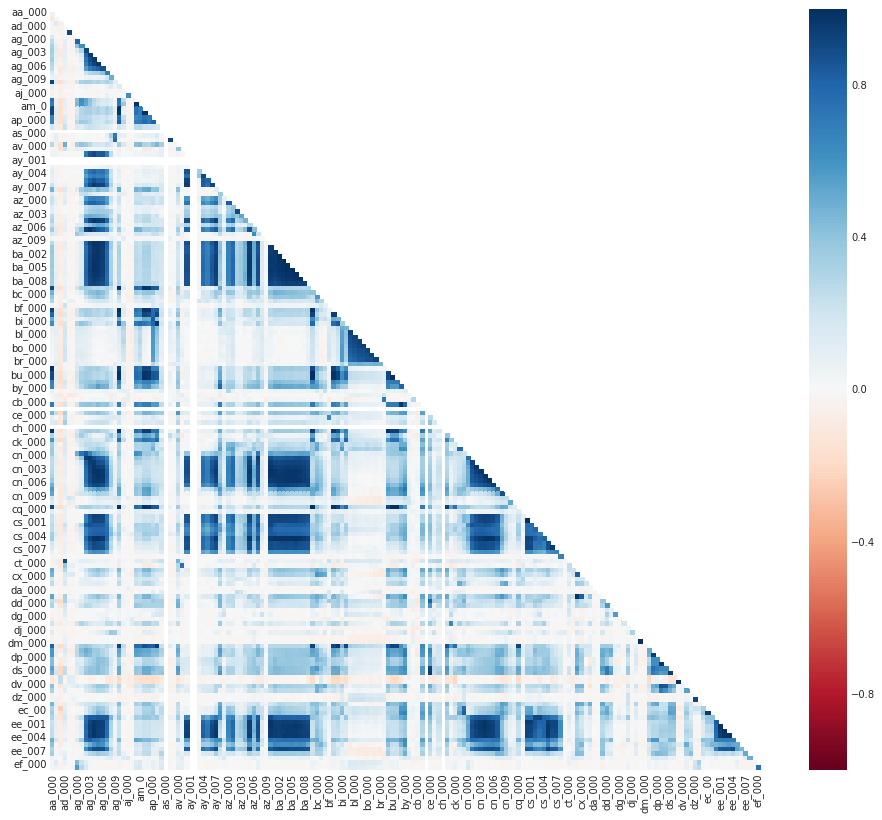

In [51]:
corr_ = train_clean.corr()
mask = np.zeros_like(corr_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 14))
sns.heatmap(corr_, mask=mask, cmap='RdBu', vmin=-1, vmax=1);

# Handle Missing value

## Imputing with a constant

In [3]:
y = train['class']
X = train.drop('class', axis=1)

In [4]:
X = X.fillna(-999)

In [17]:
corr_ = X.corr()

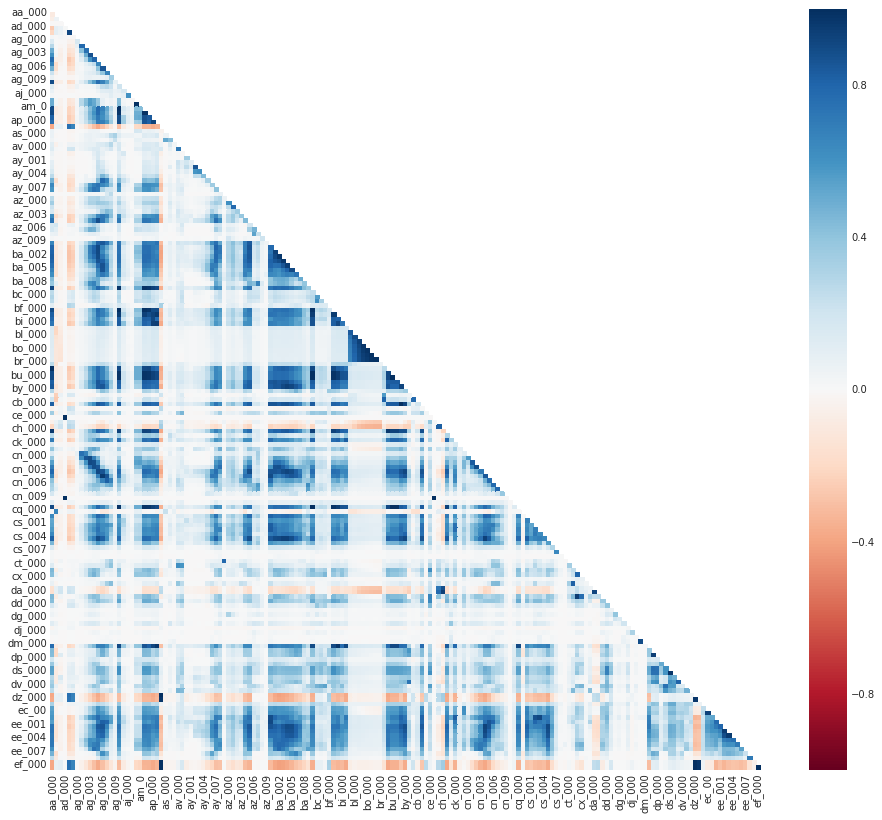

In [18]:
# corr_ = train_clean.corr()
mask = np.zeros_like(corr_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 14))
sns.heatmap(corr_, mask=mask, cmap='RdBu', vmin=-1, vmax=1);

In [19]:
s = corr_.abs().unstack()
so = s.sort_values(ascending=False)

In [20]:
# Source: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
# chrisalbon.com contains a lot of usefull code snippets

# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [25]:
max_corelations = pd.Series(index=upper.columns)

for column in upper.columns:
#     max_corelations.append((column, max(upper[column])))
    max_corelations[column] = max(upper[column])

# sorted(max_corelations, key= lambda t: t[1], reverse=True)
max_corelations.sort_values()

ad_000    0.002220
ag_000    0.018586
cs_009    0.033813
dj_000    0.048077
ac_000    0.063877
df_000    0.084042
ab_000    0.086436
cy_000    0.092626
dl_000    0.129614
cp_000    0.159580
ag_001    0.165408
ay_000    0.167804
aj_000    0.170821
as_000    0.171939
cl_000    0.173575
dh_000    0.201217
az_009    0.207556
bk_000    0.216877
ay_002    0.221690
dq_000    0.251036
ae_000    0.259825
ay_009    0.261794
bc_000    0.270152
cd_000    0.271663
ai_000    0.276298
av_000    0.281485
cs_007    0.298475
az_000    0.305790
dk_000    0.314707
az_006    0.319002
            ...   
bj_000    0.952350
ee_004    0.955956
cn_005    0.956864
bh_000    0.957995
ci_000    0.963663
ba_003    0.965006
ba_004    0.967022
dt_000    0.969685
dn_000    0.970191
bo_000    0.970286
ea_000    0.976331
bp_000    0.980926
bb_000    0.985092
bq_000    0.985630
an_000    0.985776
ao_000    0.987798
am_0      0.988664
br_000    0.989683
bu_000    0.995908
cc_000    0.996197
bg_000    0.997513
dz_000    0.

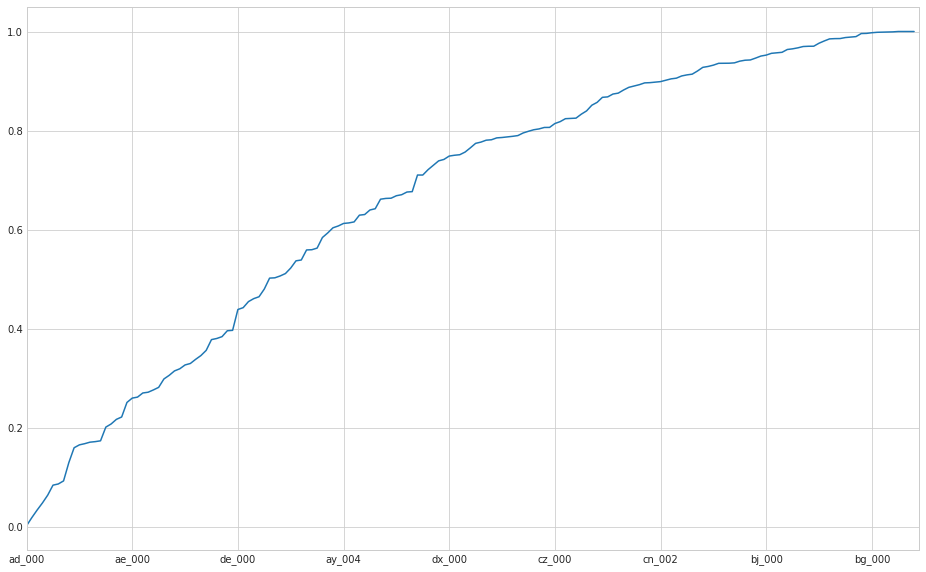

In [32]:
max_corelations.sort_values().plot(figsize=(16, 10))
# plt.ylim((0.85, 1.0))

In [19]:
len(to_drop)

30

In [20]:
to_drop

['am_0',
 'an_000',
 'ao_000',
 'ba_003',
 'ba_004',
 'bb_000',
 'bg_000',
 'bh_000',
 'bj_000',
 'bo_000',
 'bp_000',
 'bq_000',
 'br_000',
 'bt_000',
 'bu_000',
 'bv_000',
 'cc_000',
 'cf_000',
 'ci_000',
 'cn_005',
 'co_000',
 'cq_000',
 'dc_000',
 'dn_000',
 'dt_000',
 'dz_000',
 'ea_000',
 'ee_004',
 'ef_000',
 'eg_000']

(0.0, 1e-57)

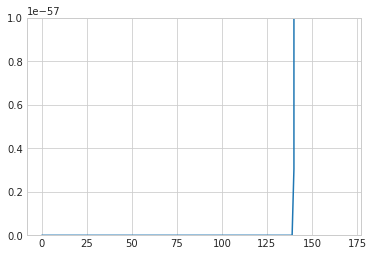

In [28]:
plt.plot(np.sort(select_best.pvalues_))
# plt.yscale('log')
plt.ylim((0.0, 1))

In [35]:
X_cleaned = X.drop(to_drop, axis=1)

In [38]:

from sklearn.preprocessing import StandardScaler

In [37]:
X_sample, _, y_sample, _ = train_test_split(X_cleaned, y, train_size=20000)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [47]:
X_scaled = StandardScaler().fit_transform(X_sample)

In [40]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA()
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

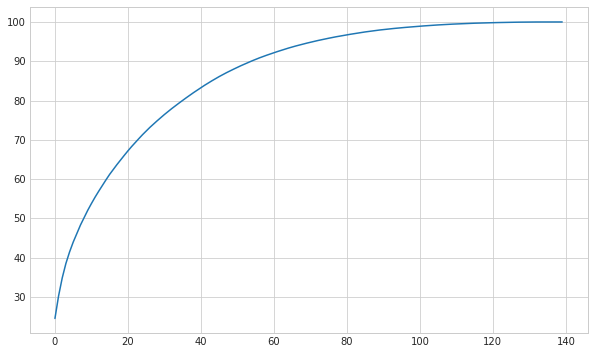

In [49]:
# Cumulative explained variance plot
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100);

In [55]:
# for easy distinction between the two classes
colors = {
    'neg': 'green',  # Normal transactions
    'pos': 'red'     # Fraud transactions
}

def get_tsne(perplexity=30, n_iter=1000, verbose=0):
    start_time = time.clock()
    X_tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, verbose=verbose, n_jobs=-1).fit_transform(X_scaled)
    total_time = time.clock() - start_time
    print(f'Time to run T-SNE: {total_time:4.1f} seconds')    
    return pd.DataFrame(data={'Dim1': X_tsne[:, 0], 'Dim2': X_tsne[:, 1], 'label': y_sample})

def plot_tsne(tsne_df):
    sns.FacetGrid(tsne_df, hue="label", size=10, palette=colors).map(plt.scatter, "Dim1", "Dim2", alpha=0.4).add_legend()


In [51]:
X_tsne = get_tsne()

Time to run T-SNE: 278.6 seconds


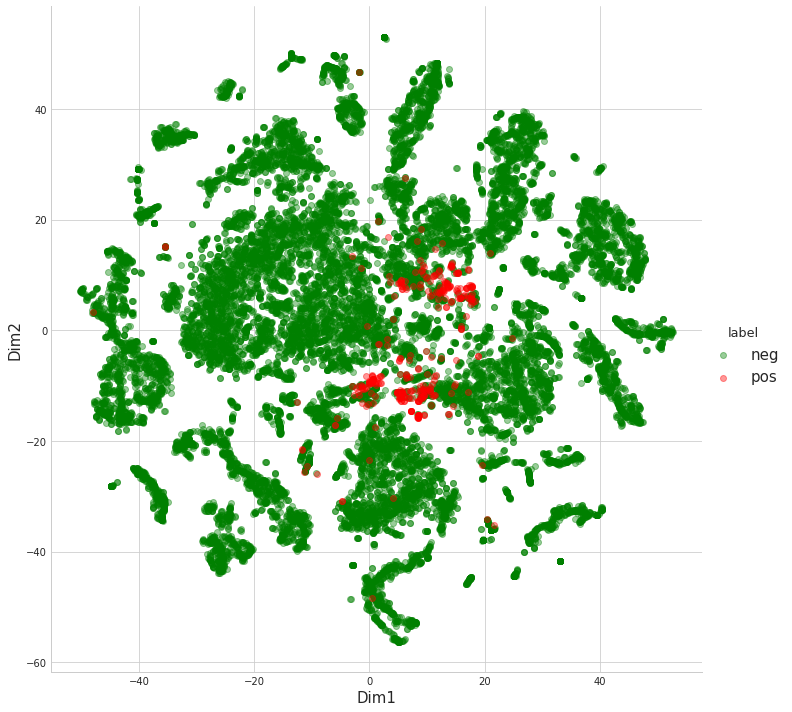

In [56]:
plot_tsne(X_tsne)

In [4]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [5]:
class ConstantImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, const=-999):
        self.const = const
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.const)

In [6]:
class CorrFilter(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.corr_ = None
        self.max_correlation = None
        self.to_drop = None
    
    def fit(self, X, y=None):
        # Source: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
        
        # Create correlation matrix
        self.corr_ = X.corr()
        
        # Select upper triangle of correlation matrix
        upper = self.corr_.where(np.triu(np.ones(self.corr_.shape), k=1).astype(np.bool))
        
        # Save feature columns with correlation greater than threshold
        self.to_drop = [column for column in upper.columns 
                        if any(upper[column] > self.threshold)]
        
        self.max_correlations = pd.Series(index=upper.columns)
        
        for column in upper.columns:
            self.max_correlations[column] = max(upper[column])
        
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.to_drop, axis=1)
        
    
    def plot_corr(self, figsize=(16, 14)):
        # Source: https://seaborn.pydata.org/generated/seaborn.heatmap.html
        mask = np.zeros_like(self.corr_)
        mask[np.triu_indices_from(mask)] = True
        plt.figure(figsize=figsize)
        sns.heatmap(self.corr_, mask=mask, cmap='RdBu', vmin=-1, vmax=1)

In [7]:
from sklearn.pipeline import Pipeline

In [8]:
preprocessor = Pipeline([
    ('constimputer', ConstantImputer()),
    ('corrfilter', CorrFilter())
])

In [9]:
X_cleaned = preprocessor.fit_transform(X)

In [69]:
preprocessor.named_steps['corrfilter'].to_drop.__len__()

30

In [71]:
X_cleaned.shape

(60000, 140)

In [45]:
# for easy distinction between the two classes
colors = {
    'neg': 'green',
    'pos': 'red'
}

def plot_tsne(X, y, sample_size=20000, perplexity=30, n_iter=1300, scale_input=True, n_jobs=-1, verbose=0):
    
    X, _, y, _ = train_test_split(X, y, train_size=sample_size)
    
    if scale_input:
        X = StandardScaler().fit_transform(X)
    
    start_time = time.clock()
    X_tsne = TSNE(n_components=2, 
                  perplexity=perplexity, 
                  n_iter=n_iter, 
                  verbose=verbose, 
                  n_jobs=n_jobs
                 ).fit_transform(X)
    total_time = time.clock() - start_time
    print(f'Time to run T-SNE: {total_time:4.1f} seconds')
    
    tsne_df = pd.DataFrame(data={'Dim1': X_tsne[:, 0], 
                                 'Dim2': X_tsne[:, 1], 
                                 'label': y})
    
    sns.FacetGrid(tsne_df, hue="label", size=10, palette=colors) \
        .map(plt.scatter, "Dim1", "Dim2", alpha=0.4) \
        .add_legend()
    

In [11]:
X_sample, _, y_sample, _ = train_test_split(X_cleaned, y, train_size=20000)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time to run T-SNE: 392.3 seconds


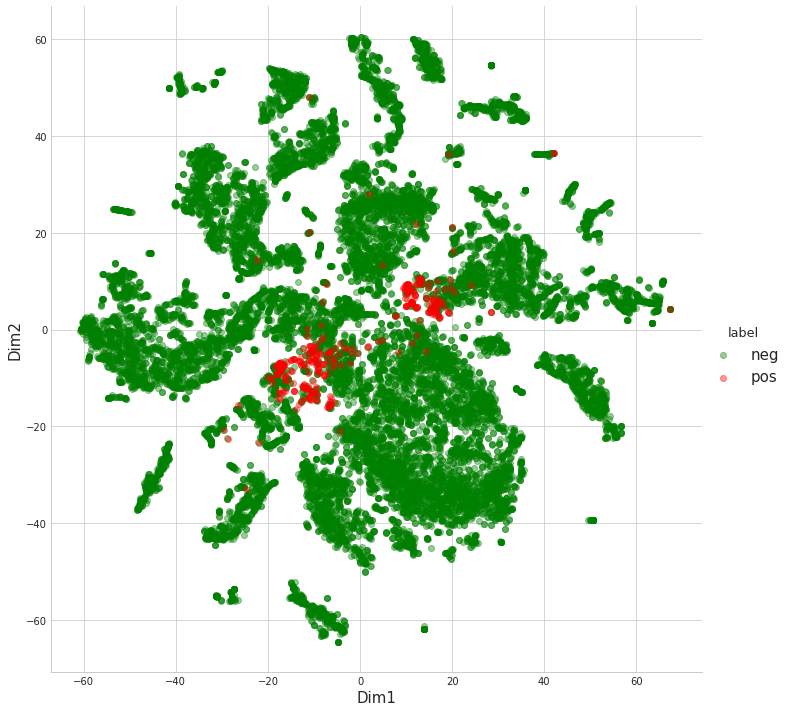

In [12]:
plot_tsne(X_sample, y_sample)

In [14]:
select_best = SelectKBest()
select_best.fit(X_cleaned, y)

SelectKBest(k=10, score_func=<function f_classif at 0x3fff09b598c8>)

In [15]:
np.sort(select_best.pvalues_)

array([  0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+

(120, 140)

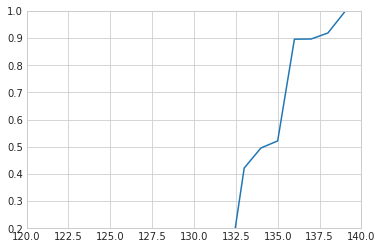

In [20]:
plt.plot(np.sort(select_best.pvalues_))
# plt.yscale('log')
plt.ylim((0.2, 1))
plt.xlim((120, 140))

In [18]:
(select_best.pvalues_ > 0.5).sum()

5

In [36]:
class SelectpValue(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.score_ = None
        self.pvalues_ = None
        self.to_drop = None
    
    def fit(self, X, y):
        model = SelectKBest()
        model.fit(X, y)
        self.score_ = model.scores_
        self.pvalues_ = model.pvalues_
        
        self.to_drop = [col for index, col in enumerate(X.columns) 
                        if self.pvalues_[index] > self.threshold]
        
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.to_drop, axis=1)
        
        

In [39]:
preprocessor = Pipeline([
    ('constimputer', ConstantImputer()),
    ('corrfilter', CorrFilter()),
    ('filterbypvalue', SelectpValue())
])

In [40]:
X_cleaned = preprocessor.fit_transform(X, y)

In [41]:
X_cleaned.columns

Index(['aa_000', 'ac_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002',
       'ag_003', 'ag_004', 'ag_005',
       ...
       'ed_000', 'ee_000', 'ee_001', 'ee_002', 'ee_003', 'ee_005', 'ee_006',
       'ee_007', 'ee_008', 'ee_009'],
      dtype='object', length=135)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time to run T-SNE: 362.4 seconds


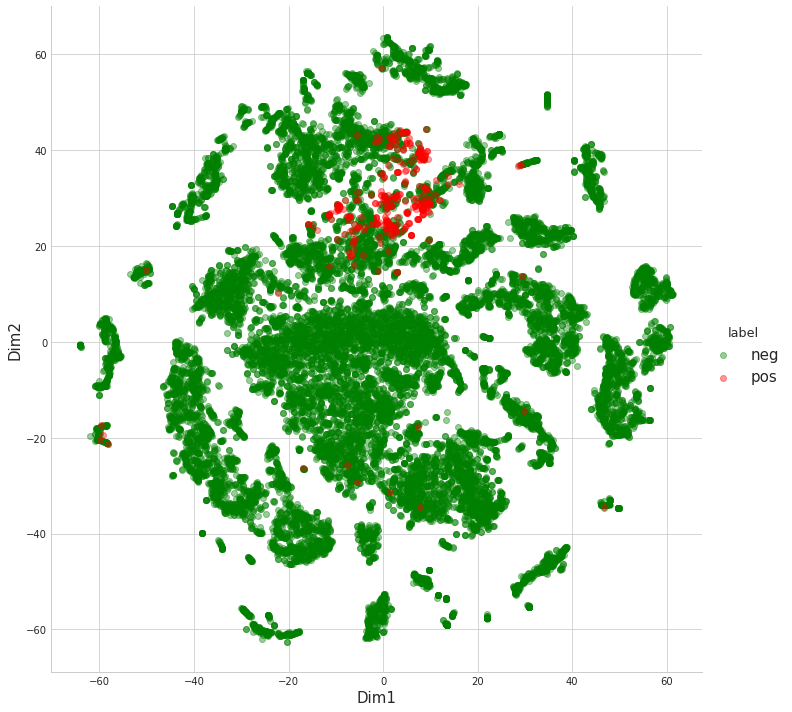

In [46]:
plot_tsne(X_cleaned, y)

In [ ]:
plot_tsne(X_cleaned, y, perplexity=50)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Time to run T-SNE: 411.5 seconds
